Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# 1. Подготовка данных

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import time 

from sklearn.metrics import mean_squared_error as mse 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler

from catboost import CatBoostRegressor 
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

RND = 12345

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

new_columns = df.columns.str.lower()
df.set_axis(new_columns, axis = 'columns', inplace = True)

Выгрузили данные и изменили названия столбцов в нижний регистр для удобства

In [3]:
def first_check(dataset):
    print(dataset.info())
    display(dataset.head())
    display(dataset.tail())
    display(df.describe())
    display(df.describe(include=['object', 'bool']))
    print('Duplicates: ', dataset.duplicated().sum())

In [4]:
first_check(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
datecrawled          354369 non-null object
price                354369 non-null int64
vehicletype          316879 non-null object
registrationyear     354369 non-null int64
gearbox              334536 non-null object
power                354369 non-null int64
model                334664 non-null object
kilometer            354369 non-null int64
registrationmonth    354369 non-null int64
fueltype             321474 non-null object
brand                354369 non-null object
notrepaired          283215 non-null object
datecreated          354369 non-null object
numberofpictures     354369 non-null int64
postalcode           354369 non-null int64
lastseen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB
None


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


,price,registrationyear,power,kilometer,registrationmonth,numberofpictures,postalcode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


,datecrawled,vehicletype,gearbox,model,fueltype,brand,notrepaired,datecreated,lastseen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,91457,268251,29232,216352,77013,247161,13719,17


Duplicates:  4


**Первичный анализ:**
- 354365 строк и 16 столбцов
- Присутствуют пропуски
- Средняя стоимость авто 2700 евро
- Минимальный год регистриции автомобиля 1000, максимальный - 9999. Предлагаю обозначить диапазон в годах, выделенных из процентилей
- Макс.значение в мощности автомобиля в лошадинных силах = 20 000. Показатель весьма фантастический. Выберем диапазон из процентилей
- Минимальный пробег авто 5000, максимальный - 150000, но при этом много авто имееют максимальный пробег. Возможно просто ограничение ввода данных на сайте
- Неправильно выставлены месяцы. Если первый месяц 0, то последний месяц не должен быть 12
- Столбец с фото автомобилей. У нас их нет

**-------------**

- 8 уникальных типов автомобильного кузова
- Чаще встречаются авто с ручной коробкой передач
- Чаще встречаются автомобиле на бензине
- Самый популярный бренд автомо Volkswagen
- Много пропусков в столбце о ремонте авто, но чаще встречаютс автомобили без ремонта

В датасете присутствуют неинформативные признаки. Предлагаю не тратить на них время и работать в дальнейшем только с нужнами признаками.

### Анализ и обработка

**Категориальные признаки**

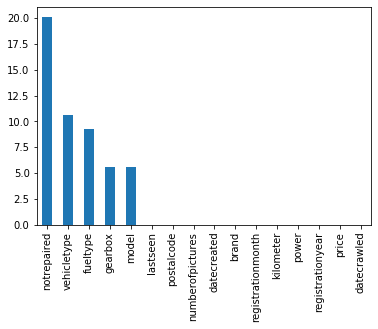

In [5]:
(df.isna().sum().sort_values(ascending=False) / df.shape[0] * 100).plot(kind='bar')

 **Объем пропущенных значений составляют: **
 - 20% в столбце NotRepaired. Скорее всего владельцы пропустили это значения потому что авто прежде не ремонтировалось. Либо просто скрыли информацию, чтобы автомобиль не казался менее привлекательным к покупке
 - 10% в столбце VehicleType 
 - 9% в столбце FuelType
 - 5% в столбце GearBox
 - 5% в столбце Model

Остальные столбцы имеют пропуски возможно по причине проблем с выгрузкой данных, так как на эти вопросы может ответить только владельцы автомобилей. Заполним пропуски модами с помощью группировки по другим признакам объектов.

In [6]:
df['notrepaired'] = df['notrepaired'].fillna('no')

In [7]:
def fill_with_mode(column, column1, column2):
    df[column] = df.groupby([column1, column2])[column].transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else "Empty")))

In [8]:
fill_with_mode('model', 'brand', 'registrationyear')
fill_with_mode('fueltype', 'brand', 'model')
fill_with_mode('vehicletype', 'brand', 'model')
fill_with_mode('gearbox', 'brand', 'model')

In [9]:
filled_columns = ['model', 'gearbox', 'brand', 'vehicletype', 'fueltype']
def count_empty_category(column):
    print(column, ' : ' ,df[column][df[column] == 'Empty'].count())

In [10]:
for column in filled_columns:
    count_empty_category(column)

model  :  3442
gearbox  :  21
brand  :  0
vehicletype  :  25
fueltype  :  14


3442 объекта продажи с неизвестными моделями авто. Предлагаю их переименовать в Other. Остальные показатели малы.

In [11]:
df['model'] = df['model'].replace('Empty', 'other')

In [12]:
def make_plotbar(index, title):
    pivot = pd.DataFrame(df.pivot_table(index=index, aggfunc="size").sort_values(ascending=False)).head(10)
    pivot.columns = ['count']
    plt.figure(figsize=(12,6))
    plt.title(title)
    sns.barplot(x='count', y=pivot.index, data=pivot)

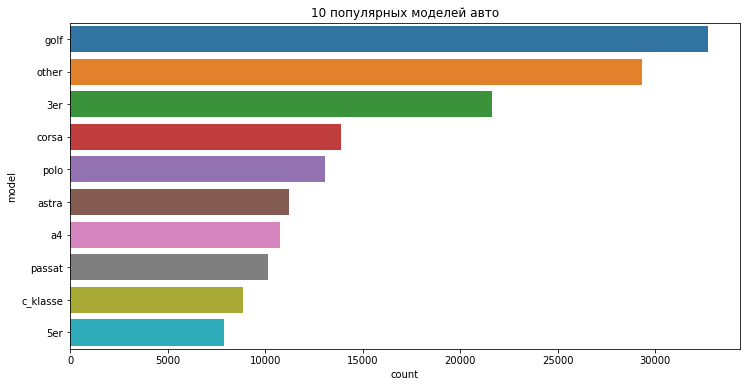

In [13]:
make_plotbar('model', '10 популярных моделей авто')

Самая популярная модель авто - golf

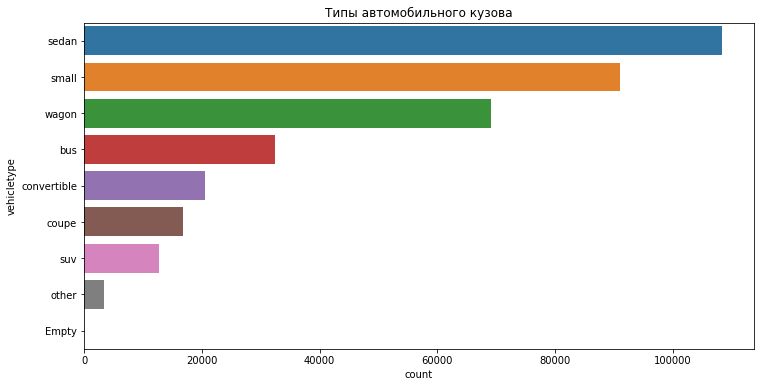

In [14]:
make_plotbar('vehicletype', 'Типы автомобильного кузова')

Самый популярный тип автомобильного кузова - седан

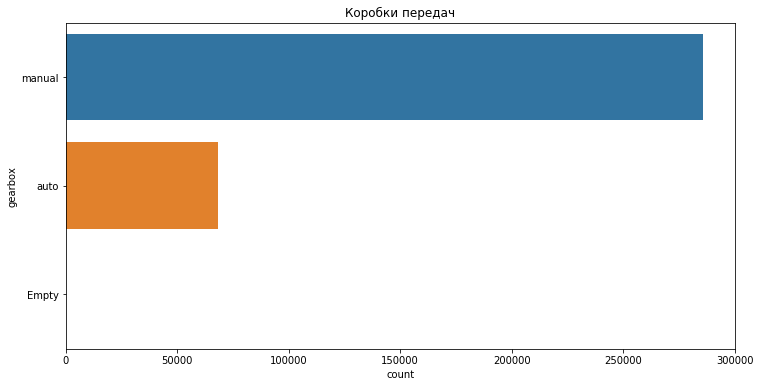

In [15]:
make_plotbar('gearbox', 'Коробки передач')

Автомобили с ручной коробкой передач превышают по количеству автомобили с автоматической коробкой передач

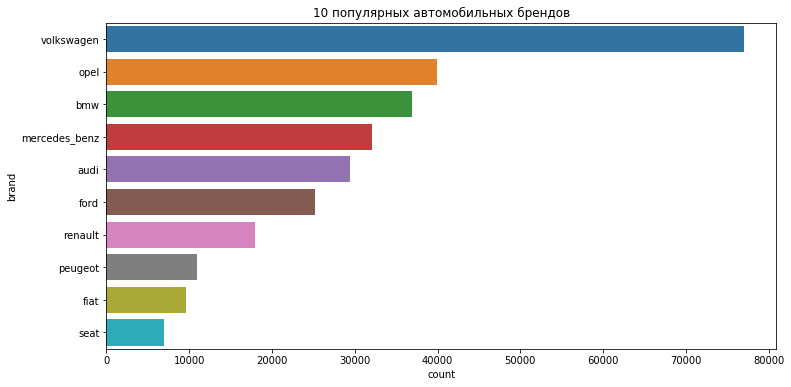

In [16]:
make_plotbar('brand', '10 популярных автомобильных брендов')

Volskwagen - самый продаваемый автомобиль

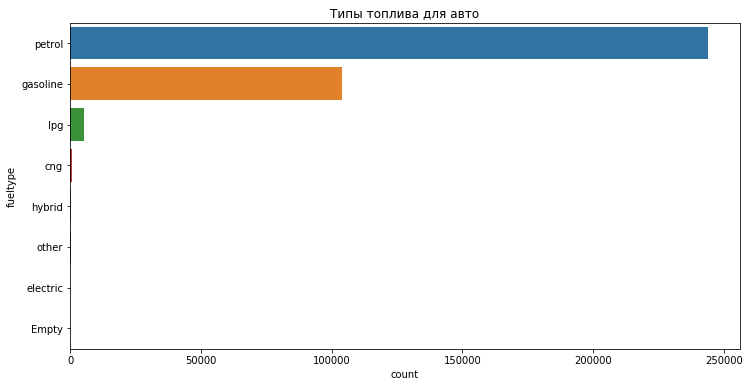

In [17]:
make_plotbar('fueltype', 'Типы топлива для авто')

Бензин - самое популярное топливо

**Количественные признаки**

In [18]:
cars_for_free = df.query('price == 0')
cars_for_free.shape

(10772, 16)

10772 автомобиля отдаются бесплатно. На фоне остального датасета это немного строк. Предлагаю их просто убрать

In [19]:
df = df.query('price != 0')

In [20]:
perc = np.arange(0,1,0.05)

In [21]:
df['power'].describe(percentiles = perc)

count    343597.000000
mean        111.000192
std         188.177974
min           0.000000
0%            0.000000
5%            0.000000
10%           0.000000
15%          54.000000
20%          60.000000
25%          69.000000
30%          75.000000
35%          82.000000
40%          90.000000
45%         101.000000
50%         105.000000
55%         110.000000
60%         116.000000
65%         125.000000
70%         136.000000
75%         143.000000
80%         150.000000
85%         170.000000
90%         180.000000
95%         218.000000
max       20000.000000
Name: power, dtype: float64

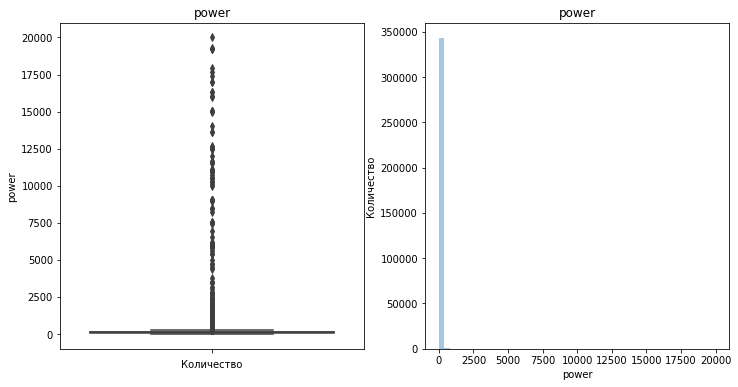

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_title('power')
sns.boxplot(y = 'power', data=df, ax = axes[0])
axes[0].set_xlabel('Количество')
     
axes[1].set_title('power')
sns.distplot(df['power'], kde=False, bins=50, ax = axes[1])
axes[1].set_ylabel('Количество')
            
plt.show()

много выбросов, от этого график становится неинформативным

Text(0, 0.5, 'Количество')

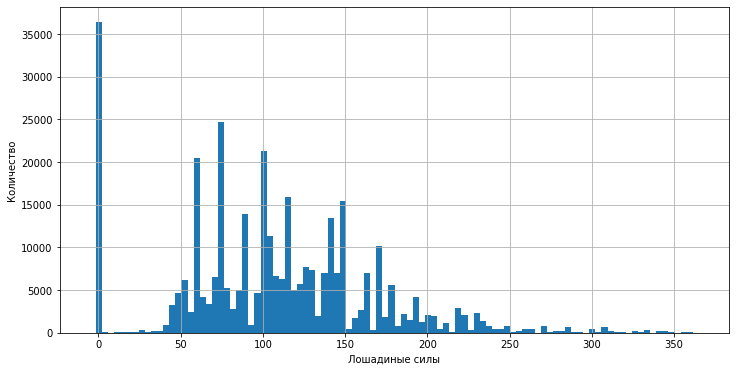

In [23]:
Q1 = df['power'].quantile(0.25)
Q3 = df['power'].quantile(0.75)
IQR = Q3 - Q1
fig, ax = plt.subplots()
df['power'].plot(kind = 'hist', bins = 100, grid = True, range = (Q1 - IQR, Q3 + 3*IQR), figsize = (12, 6))
ax.set_xlabel('Лошадиные силы')
ax.set_ylabel('Количество')

Мы взяли квантили от показателей столбца для графика, и судя по нему в основном встречаются авто с мощностью до 350 лс. Примем 350 лс как максимум диапазона, а нули заменим на медианы относительно групп моделей объектов

In [24]:
df = df.query('power <= 350')

In [25]:
medians  = df.groupby('model')['power'].median().to_dict()
def fill_with_median (row):
    if row['power'] == 0:
        return medians [row['model']]
    return row ['power']
df['power'] = df.apply(lambda row: fill_with_median(row), axis = 1)

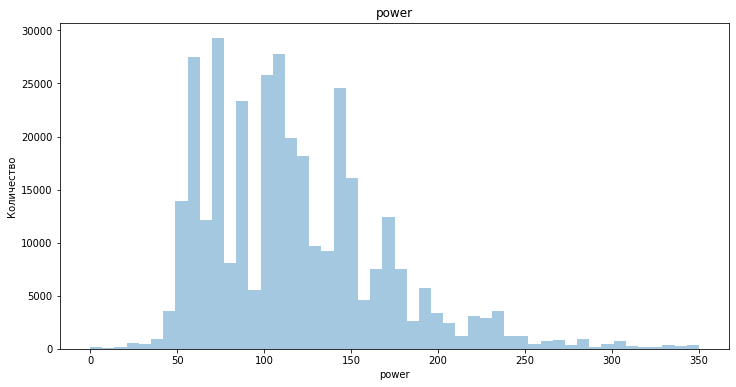

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title('power')
sns.distplot(df['power'], kde=False, bins=50, ax = ax)
ax.set_ylabel('Количество')          
plt.show()

Убрали выбросы и нули из столбца Power

In [27]:
df['registrationyear'].describe(percentiles=perc)

count    342441.000000
mean       2004.074962
std          77.973936
min        1000.000000
0%         1000.000000
5%         1993.000000
10%        1996.000000
15%        1997.000000
20%        1998.000000
25%        1999.000000
30%        2000.000000
35%        2000.000000
40%        2001.000000
45%        2002.000000
50%        2003.000000
55%        2004.000000
60%        2005.000000
65%        2006.000000
70%        2007.000000
75%        2008.000000
80%        2009.000000
85%        2010.000000
90%        2012.000000
95%        2016.000000
max        9999.000000
Name: registrationyear, dtype: float64

Возьмем область от 5% в столбе года регистрации

In [28]:
df = df.query('registrationyear >= 1992 and registrationyear < 2020')

In [29]:
df = df.drop_duplicates().reset_index(drop=True)

Убрали дубликаты

In [30]:
def make_price_plot(feature, title):
    mean_price = df[[feature, 'price']].groupby(feature, as_index=False).mean().astype('int')
    plt.figure(figsize=(12,6))
    plt.grid(axis = 'both')
    sns.lineplot(x=feature, y='price', data=mean_price)
    plt.xlabel(feature, size=12)
    plt.ylabel('Средняя цена в евро', size=12)
    plt.title(title, size=15, y=1.02)
    plt.show()

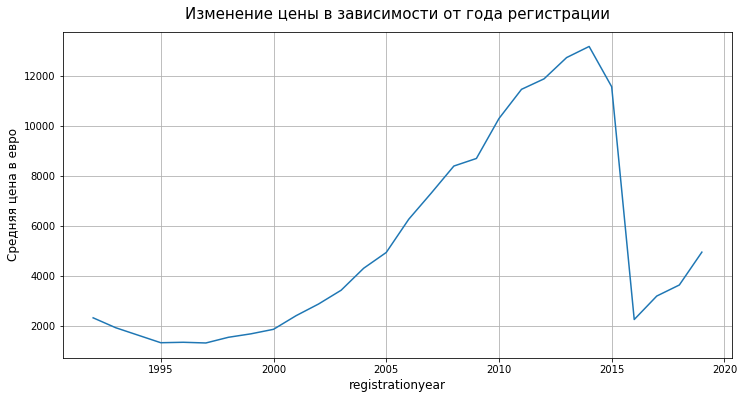

In [31]:
make_price_plot('registrationyear', 'Изменение цены в зависимости от года регистрации')

Кризис в 2015?

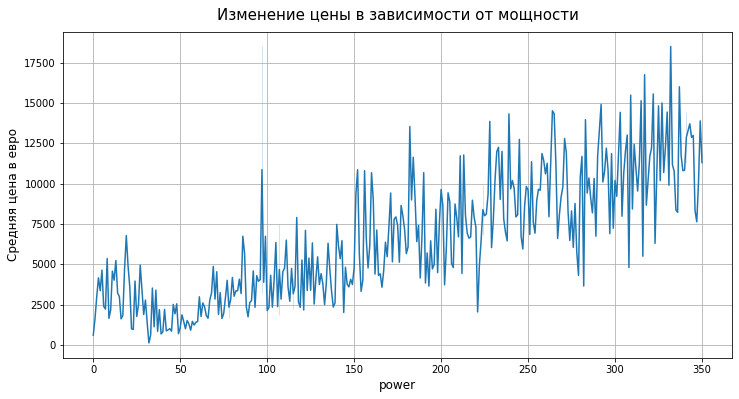

In [32]:
make_price_plot('power', 'Изменение цены в зависимости от мощности')

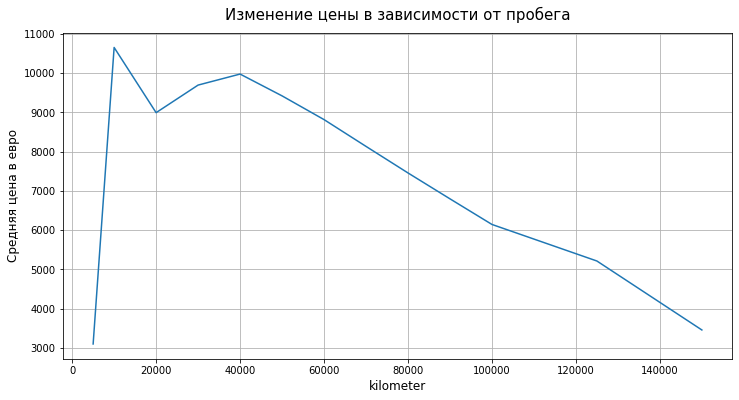

In [33]:
make_price_plot('kilometer', 'Изменение цены в зависимости от пробега')

In [34]:
df.shape

(328421, 16)

После анализа и обработки мы потеряли 1\10 данных. Надеюсь это не сильно повлияет на дальнейшую работу

# 2. Обучение моделей

Features: 
 - Object: 
       'vehicletype', 'registrationyear', 'gearbox',
       'model', 'fueltype', 'brand',
       'notrepaired'
 - Int: 'power', 'kilometer'

Target: 'price'

Уберем ненужные столбцы

In [35]:
df = df.drop(['datecrawled', 'datecreated', 'numberofpictures', 'postalcode', 'lastseen'], axis=1)

In [36]:
cats_cols = list(df.select_dtypes(include='object').columns)
label_encode = LabelEncoder()
for column in cats_cols:
    label_encode.fit(df[column].astype('str'))
    df[column] = label_encode.transform(df[column].astype('str'))

Провели кодирование категориальных данных с помощью Label Encoder

In [37]:
cats_cols

['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']

In [38]:
features = df.drop('price', axis=1)
target = df['price']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=RND)
X_train_valid, X_test_valid, y_train_valid, y_test_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=RND)

Поделили данные на обучающую, тестовую и валидационную выборки

In [40]:
def scale_to_standard(train, test, valid):
    scaler = StandardScaler()
    quanti_columns = ['registrationyear', 'power', 'kilometer']
    scaler.fit(train[quanti_columns])
    train[quanti_columns] = scaler.transform(train[quanti_columns])
    valid[quanti_columns]=scaler.transform(valid[quanti_columns])
    test[quanti_columns] = scaler.transform(test[quanti_columns])

In [41]:
scale_to_standard(X_train, X_test, X_train_valid)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

Стандартизировали их

### LGB Regressor

In [42]:
def lgb_regr(features, target):
    model = LGBMRegressor()
    params = {
        'boosting_type' : ['gbdt'],
        'n_estimators' : [50, 100],
        'max_depth' : [5, 7, 10],
        'verbose' : [0],
        'random_state' : [RND],
        'force_col_wise': [True],
        'num_leaves' : [127]}
    grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_cv.fit(features, target, categorical_feature=cats_cols)
    print('Best hyperparams: ', grid_cv.best_params_)
    print('RMSE score on train sample: {:.2f}'.format((-grid_cv.best_score_) ** 0.5))
    return grid_cv.best_params_

In [43]:
%%time
lgb_params = lgb_regr(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fueltype', 'gearbox', 'model', 'notrepaired', 'vehicletype']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fueltype', 'gearbox', 'model', 'notrepaired', 'vehicletype']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fueltype', 'gearbox', 'model', 'notrepaired', 'vehicletype']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset

Best hyperparams:  {'boosting_type': 'gbdt', 'force_col_wise': True, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 127, 'random_state': 12345, 'verbose': 0}
RMSE score on train sample: 1548.44
CPU times: user 5min 36s, sys: 3.05 s, total: 5min 39s
Wall time: 5min 43s


In [44]:
%%time
model_lgb = LGBMRegressor(**lgb_params)
model_lgb.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=10, eval_metric='rmse')
predict_lgb = model_lgb.predict(X_train_valid)
print('Test RMSE = {:.2f}'.format(mse(y_train_valid, predict_lgb)**0.5))

[10]	valid_0's rmse: 2438.22	valid_0's l2: 5.94493e+06
[20]	valid_0's rmse: 1901.26	valid_0's l2: 3.61477e+06
[30]	valid_0's rmse: 1743.72	valid_0's l2: 3.04056e+06
[40]	valid_0's rmse: 1677.69	valid_0's l2: 2.81465e+06
[50]	valid_0's rmse: 1647.79	valid_0's l2: 2.71523e+06
[60]	valid_0's rmse: 1628.85	valid_0's l2: 2.65315e+06
[70]	valid_0's rmse: 1614.82	valid_0's l2: 2.60765e+06
[80]	valid_0's rmse: 1601.62	valid_0's l2: 2.56519e+06
[90]	valid_0's rmse: 1592.5	valid_0's l2: 2.53605e+06
[100]	valid_0's rmse: 1584.53	valid_0's l2: 2.51073e+06
Test RMSE = 1593.78
CPU times: user 20.9 s, sys: 145 ms, total: 21.1 s
Wall time: 21.4 s


Использовав модель LGBMRegressor мы получили показатели: 
 - на обучающей выборке: 1550.04
 - на валидационной выборке: 1593.78

### CatBoostRegressor

In [45]:
def catboost_regr(features, target):
    model = CatBoostRegressor()
    params = {
            'n_estimators' : [50, 100],
            'verbose' : [0],
            'random_state' : [RND],
            'max_depth' : [5, 7, 10]
    }
    grid_cv = GridSearchCV(estimator=model, 
    param_grid=params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_cv.fit(features, target, cat_features=cats_cols, verbose=10)
    print('Best hyperparams: ', grid_cv.best_params_)
    print('RMSE score on train sample: {:.2f}'.format((-grid_cv.best_score_) ** 0.5))
    return grid_cv.best_params_

In [46]:
%%time
catb_params = catboost_regr(X_train, y_train)

0:	learn: 4407.8664899	total: 176ms	remaining: 8.61s
10:	learn: 3705.0685789	total: 2.27s	remaining: 8.05s
20:	learn: 3213.1902540	total: 4.27s	remaining: 5.89s
30:	learn: 2867.9715025	total: 6.25s	remaining: 3.83s
40:	learn: 2617.7456727	total: 8.25s	remaining: 1.81s
49:	learn: 2450.2292171	total: 10s	remaining: 0us
0:	learn: 4410.9921458	total: 138ms	remaining: 6.76s
10:	learn: 3712.3983768	total: 2.23s	remaining: 7.91s
20:	learn: 3213.9966509	total: 4.23s	remaining: 5.84s
30:	learn: 2871.5600549	total: 6.22s	remaining: 3.81s
40:	learn: 2628.5184947	total: 8.22s	remaining: 1.8s
49:	learn: 2455.4339069	total: 10s	remaining: 0us
0:	learn: 4405.7999343	total: 171ms	remaining: 8.4s
10:	learn: 3707.8509256	total: 2.27s	remaining: 8.05s
20:	learn: 3218.9990871	total: 4.36s	remaining: 6.03s
30:	learn: 2872.9948933	total: 6.36s	remaining: 3.9s
40:	learn: 2627.9833524	total: 8.45s	remaining: 1.85s
49:	learn: 2457.6542614	total: 10.2s	remaining: 0us
0:	learn: 4407.8664899	total: 153ms	remainin

In [47]:
%%time
catb_model = CatBoostRegressor(**catb_params)
catb_model.fit(X_train, y_train, verbose=10)
catb_pred = catb_model.predict(X_train_valid)
print('Test RMSE : {:.2f} '.format(mse(y_train_valid, catb_pred)**0.5))

0:	learn: 4393.3068740	total: 223ms	remaining: 22.1s
10:	learn: 3583.3560193	total: 3.12s	remaining: 25.2s
20:	learn: 3023.8825421	total: 6s	remaining: 22.6s
30:	learn: 2641.0376368	total: 8.9s	remaining: 19.8s
40:	learn: 2381.3765505	total: 11.8s	remaining: 17s
50:	learn: 2202.6946299	total: 14.7s	remaining: 14.1s
60:	learn: 2083.3561221	total: 17.6s	remaining: 11.2s
70:	learn: 1998.1542330	total: 20.5s	remaining: 8.36s
80:	learn: 1935.6113391	total: 23.4s	remaining: 5.48s
90:	learn: 1888.6576597	total: 26.2s	remaining: 2.6s
99:	learn: 1853.0813173	total: 28.8s	remaining: 0us
Test RMSE : 1894.91 
CPU times: user 26.3 s, sys: 3.14 s, total: 29.5 s
Wall time: 31 s


Использовав модель CatBoostRegressor мы получили показатели: 
 - на обучающей выборке: 1588.17
 - на валидационной выборке: 1591.36 

### XGBRegressor

In [48]:
def xgb_regr(features, target):
    model = XGBRegressor()
    params = {
        'max_depth': [3, 5, 7], 
         'eta': [0.5], 
         'min_child_weight':[4],
         'sampling_method':['gradient_based'], 
         'verbosity':[1],  
         'seed':[RND]}
    grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=2, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_cv.fit(features, target, eval_metric='rmse', verbose = 10, eval_set = [(X_test, y_test)])
    print('Best hyperparams: ', grid_cv.best_params_)
    print('Best RMSE score: {:.2f}'.format((-grid_cv.best_score_) ** 0.5))
    return grid_cv.best_params_

In [49]:
%%time
xgb_params = xgb_regr(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:12:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5918.13
[10]	validation_0-rmse:3194.32
[20]	validation_0-rmse:2416.24
[30]	validation_0-rmse:2191.33
[40]	validation_0-rmse:2083.88
[50]	validation_0-rmse:2019.3
[60]	validation_0-rmse:1979.64
[70]	validation_0-rmse:1952.68
[80]	validation_0-rmse:1929.51
[90]	validation_0-rmse:1914.62
[99]	validation_0-rmse:1904.5


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:12:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5918.83
[10]	validation_0-rmse:3196.39
[20]	validation_0-rmse:2424.49
[30]	validation_0-rmse:2202.17
[40]	validation_0-rmse:2103.03
[50]	validation_0-rmse:2038.54
[60]	validation_0-rmse:1994.59
[70]	validation_0-rmse:1967.03
[80]	validation_0-rmse:1940.08
[90]	validation_0-rmse:1917.64
[99]	validation_0-rmse:1902.94


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:13:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5873.57
[10]	validation_0-rmse:2918.46
[20]	validation_0-rmse:2164.42
[30]	validation_0-rmse:1955.86
[40]	validation_0-rmse:1874.21
[50]	validation_0-rmse:1824.68
[60]	validation_0-rmse:1793.48
[70]	validation_0-rmse:1772.62
[80]	validation_0-rmse:1755.38
[90]	validation_0-rmse:1741.62
[99]	validation_0-rmse:1731.03


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:13:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5874.8
[10]	validation_0-rmse:2920.6
[20]	validation_0-rmse:2162.43
[30]	validation_0-rmse:1957.11
[40]	validation_0-rmse:1874.76
[50]	validation_0-rmse:1824.38
[60]	validation_0-rmse:1794.58
[70]	validation_0-rmse:1774.09
[80]	validation_0-rmse:1761.11
[90]	validation_0-rmse:1748.29
[99]	validation_0-rmse:1734.42


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:13:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5856.4
[10]	validation_0-rmse:2795.84
[20]	validation_0-rmse:2010.65
[30]	validation_0-rmse:1810.22
[40]	validation_0-rmse:1743.08
[50]	validation_0-rmse:1706.23
[60]	validation_0-rmse:1687.63
[70]	validation_0-rmse:1676.17
[80]	validation_0-rmse:1665.19
[90]	validation_0-rmse:1654
[99]	validation_0-rmse:1645.79


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:14:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5856.69
[10]	validation_0-rmse:2798.28
[20]	validation_0-rmse:2010.53
[30]	validation_0-rmse:1811.69
[40]	validation_0-rmse:1740.43
[50]	validation_0-rmse:1707.44
[60]	validation_0-rmse:1688.51
[70]	validation_0-rmse:1675.52
[80]	validation_0-rmse:1662.34
[90]	validation_0-rmse:1651.43
[99]	validation_0-rmse:1643.46


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:14:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5855.78
[10]	validation_0-rmse:2796.1
[20]	validation_0-rmse:2010.39
[30]	validation_0-rmse:1806.87
[40]	validation_0-rmse:1736.92
[50]	validation_0-rmse:1702.76
[60]	validation_0-rmse:1684.52
[70]	validation_0-rmse:1666.74
[80]	validation_0-rmse:1652.7
[90]	validation_0-rmse:1640.46
[99]	validation_0-rmse:1630.86
Best hyperparams:  {'eta': 0.5, 'max_depth': 7, 'min_child_weight': 4, 'sampling_method': 'gradient_based', 'seed': 12345, 'verbosity': 1}
Best RMSE score: 1636.54
CPU times: user 2min 27s, sys: 0 ns, total: 2min 27s
Wall time: 2min 27s


In [50]:
%%time
model_xgb = XGBRegressor(**xgb_params)
model_xgb.fit(X_train, y_train, eval_metric='rmse', verbose = 10, eval_set = [(X_test, y_test)])
xgb_pred = model_xgb.predict(X_train_valid)
print('Test RMSE : {:.2f}'.format(mse(y_train_valid, xgb_pred)**0.5))

[09:15:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5855.78
[10]	validation_0-rmse:2796.1
[20]	validation_0-rmse:2010.39
[30]	validation_0-rmse:1806.87
[40]	validation_0-rmse:1736.92
[50]	validation_0-rmse:1702.76
[60]	validation_0-rmse:1684.52
[70]	validation_0-rmse:1666.74
[80]	validation_0-rmse:1652.7
[90]	validation_0-rmse:1640.46
[99]	validation_0-rmse:1630.86
Test RMSE : 1643.58
CPU times: user 42.5 s, sys: 0 ns, total: 42.5 s
Wall time: 42.8 s


Использовав модель XGBRegressor мы получили показатели: 
 - на обучающей выборке: 1613.46
 - на валидационной выборке: 1581.30 

# 3. Анализ моделей

Мы провели анализ и обработку данных. Подготовили их и обучили модели на их основе. Нашли лучшие гиперпараметры для моделей и протестировали их на валидационных выборках, применив метрику RMSE.

In [51]:
results = {
    'Model' : ['LGBMRegressor', 'CatBoostRegressor', 'XGBRegressor'],
    'Train RMSE' :pd.Series([1550.04, 1588.17, 1613.46]),
    'Train Time, sec': pd.Series([26.5, 105, 38.1]),
    'Test RMSE' :pd.Series([1593.78, 1591.36, 1581.3]),
    'Test Time, sec': pd.Series([3.41, 7.25, 8.94])
    }
display(pd.DataFrame(results))

,Model,Train RMSE,"Train Time, sec",Test RMSE,"Test Time, sec"
0,LGBMRegressor,1550.04,26.5,1593.78,3.41
1,CatBoostRegressor,1588.17,105.0,1591.36,7.25
2,XGBRegressor,1613.46,38.1,1581.30,8.94


XGBRegressor показал худшие результат на обучающей выборке, но на валидационной вышел на первое место, хотя занял времени больше остальных.